In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle

In [2]:
# Script runtime options
models = ['googlenet','inception_v3','inceptionv4','pnasnet5large','resnet152','resnext101_32x8d','resnext101_64x4d','swin_base_patch4_window12_384']
color = ['r','g','b','c','m','y','k']
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [7]:
# Load model training history
history = {}
class_report = {}
confusion_matrix = {}
model_results = {}
for model in models:
    data_dir = os.path.join(data_root_dir,'images')
    output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
    model_history = os.path.join(output_dir,'model_history.pkl')
    model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))
    
    #with open(model_history,'rb') as file:
    #    history[model] = torch.load(file, map_location=lambda storage, location: 'cpu')
    history_temp = unpickle(model_history)
    for key in history_temp.keys():
        print(' {} Type :: {}'.format(key,type(history_temp[key][0])))
        if (torch.is_tensor(history_temp[key][0])) and (history_temp[key][0].device.type == 'cuda'):
            print('Converting Tensor type from GPU to CPU')
            for i, item in enumerate(history_temp[key]):
                history_temp[key][i] = history_temp[key][i].cpu().tolist()
    
    history[model] = history_temp
    
    
    
    class_report[model] = unpickle(os.path.join(output_dir,'classification_report.pkl')) #, map_location=lambda storage, location: 'cpu')
    confusion_matrix[model] = unpickle(os.path.join(output_dir,'confusion_matrix.pkl')) #, map_location=lambda storage, location: 'cpu')
    model_results[model] = unpickle(fname=os.path.join(output_dir,'model_results.pkl'))

 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 test_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 test_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 test_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 test_acc Type :: <class 'torch.Tens

In [8]:
history['googlenet'].keys()

dict_keys(['epoch', 'train_loss', 'test_loss', 'train_acc', 'test_acc'])

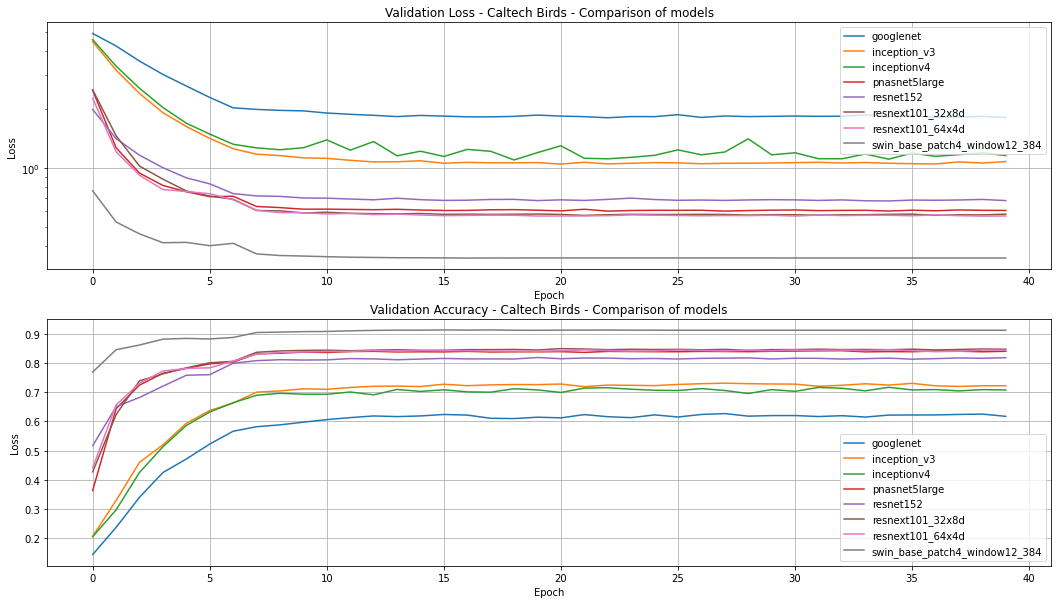

In [9]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
for model in models:
    plt.plot(np.arange(0, np.max(history[model]['epoch'])+1,1), history[model]['test_loss'], label=model)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Validation Loss - Caltech Birds - Comparison of models')
plt.legend()

plt.subplot(2,1,2)
for model in models:
    plt.plot(np.arange(0, np.max(history[model]['epoch'])+1,1), history[model]['test_acc'], label=model)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Accuracy - Caltech Birds - Comparison of models')
plt.legend()

plt.show()

In [10]:
acc = []
precision = []
recall = []
f1_score = []
for model in models:
    precision.append( class_report[model]['macro avg']['precision'] )
    recall.append( class_report[model]['macro avg']['recall'] )
    f1_score.append( class_report[model]['macro avg']['f1-score'] )
    acc.append( class_report[model]['accuracy']['precision'] )

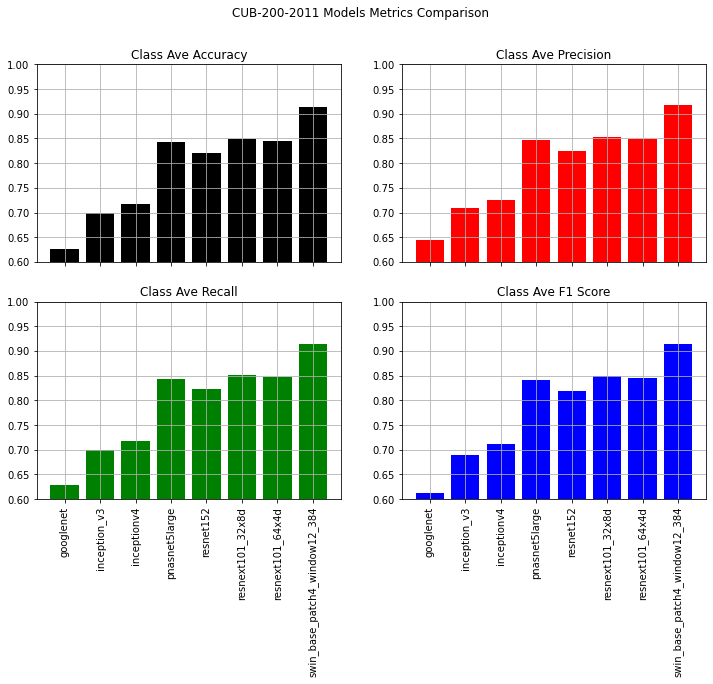

In [11]:
ylim = [0.6, 1.0]

fig = plt.figure(figsize=(12,8))
fig.suptitle('CUB-200-2011 Models Metrics Comparison')

plt.subplot(2,2,1)
plt.bar(models, height=acc, color='black')
plt.xticks(models, '')
plt.ylim(ylim)
plt.grid(True)
plt.title('Class Ave Accuracy')

plt.subplot(2,2,2)
plt.bar(models, height=precision, color='red')
plt.xticks(models, '')
plt.ylim(ylim)
plt.grid(True)
plt.title('Class Ave Precision')

plt.subplot(2,2,3)
plt.bar(models, height=recall, color='green')
plt.xticks(rotation=90)
plt.ylim(ylim)
plt.grid(True)
plt.title('Class Ave Recall')

plt.subplot(2,2,4)
plt.bar(models, height=f1_score, color='blue')
plt.xticks(rotation=90)
plt.ylim(ylim)
plt.grid(True)
plt.title('Class Ave F1 Score')

plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

def compute_precision_recall(y_true, y_probas):
    # Compute Precision-Recall curve and area for each class
    
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(
            y_true, y_probas[:, i], pos_label=classes[i])

    y_true = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true = np.hstack((1 - y_true, y_true))

    for i in range(len(classes)):
        average_precision[i] = average_precision_score(y_true[:, i], y_probas[:, i])
        
    # Compute micro-average ROC curve and ROC area
    micro_key = 'micro'
    i = 0
    while micro_key in precision:
        i += 1
        micro_key += str(i)

    precision[micro_key], recall[micro_key], _ = precision_recall_curve(
        y_true.ravel(), y_probas.ravel())
    average_precision[micro_key] = average_precision_score(y_true, y_probas,
                                                           average='micro')
    return precision, recall, average_precision

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
for i,model in enumerate(models):
    precision, recall, ave_precision = compute_precision_recall(y_true=model_results[model]['labels truth'], 
                                                                y_probas=model_results[model]['scores pred'])
    plt.plot(recall['micro'],precision['micro'], 'r', label='{} ({:1.4f} Area)'.format(model, ave_precision['micro']), color=color[i])
plt.grid(True)
plt.legend()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision Recall per model')
plt.show()